#Audio

In [1]:
!pip install kaggle


In [2]:
!nvidia-smi

Wed Feb  7 13:14:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P8              11W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
import json

kaggle_json_path = 'kaggle.json'

try :
    # Read the kaggle.json file
    with open(kaggle_json_path) as f:
       kaggle_config = json.load(f)

    userkaggle       = kaggle_config['username']
    passkaggle       = kaggle_config['key']
    os.environ['KAGGLE_USERNAME'] = userkaggle
    os.environ['KAGGLE_KEY'] = passkaggle
    print("KAGGLE_USERNAME and KAGGLE_KEY are set.")
except :
    print("KAGGLE_USERNAME or KAGGLE_KEY is not set.")

KAGGLE_USERNAME and KAGGLE_KEY are set.


In [4]:
import zipfile
import os


dataset_name = 'heartbeat-sounds'
zip_path = f'{dataset_name}.zip'

if not os.path.exists(dataset_name):
    !kaggle datasets download -d kinguistics/heartbeat-sounds
     
if not os.path.exists(dataset_name) and os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_name)




In [5]:
import glob
import os
import pandas as pd

wave_files = glob.glob('heartbeat-sounds/set_a/*.wav')
labels_files = [ os.path.basename(file).split("_")[0] for file in wave_files]




In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# create train test split from wave files and labels_files and encode the labels
# create train test split
train_files, test_files, train_labels, test_labels = train_test_split(wave_files, labels_files, test_size=0.01, random_state=42)

# encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)


In [22]:
label_encoder 

LabelEncoder()

In [7]:
from collections import Counter

label_counts = Counter(labels_files)
print(label_counts)

NUM_CLASSES = len(label_counts)

Counter({'Aunlabelledtest': 52, 'artifact': 40, 'murmur': 34, 'normal': 31, 'extrahls': 19})


In [8]:
import matplotlib.pyplot as plt
import torch

#%%
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

# source: adapted from https://pytorch.org/audio/stable/tutorials/audio_io_tutorial.html
def plot_specgram(waveform, sample_rate, file_path = 'test2.png'):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    
    fig, axes = plt.subplots( num_channels, 1)
    fig.set_size_inches(8, 8)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    plt.gca().set_axis_off()
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    # plt.show(block=False)
    plt.savefig(file_path, bbox_inches='tight', pad_inches = 0)
    

In [9]:
#%% package import
import torchaudio
import seaborn as sns   
import matplotlib.pyplot as plt
# %% check if audio backend is installed
# before: pip install soundfile
torchaudio.info

# %% data import
wav_file = wave_files[0]
data_waveform, sr = torchaudio.load(wav_file)
# %%
print("shape of waveform: {}".format(data_waveform.size())) 




shape of waveform: torch.Size([1, 349958])


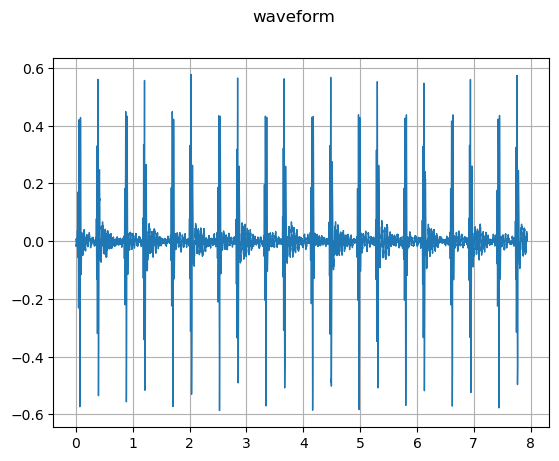

In [10]:
# %% Plot Waveform
plot_waveform(data_waveform, sample_rate=sr)
#%% calculate spectrogram

In [11]:

spectogram = torchaudio.transforms.Spectrogram(22050)(data_waveform)
print('Shape of spectrogram: {}'.format(spectogram.size()))

# %%

Shape of spectrogram: torch.Size([1, 11026, 32])


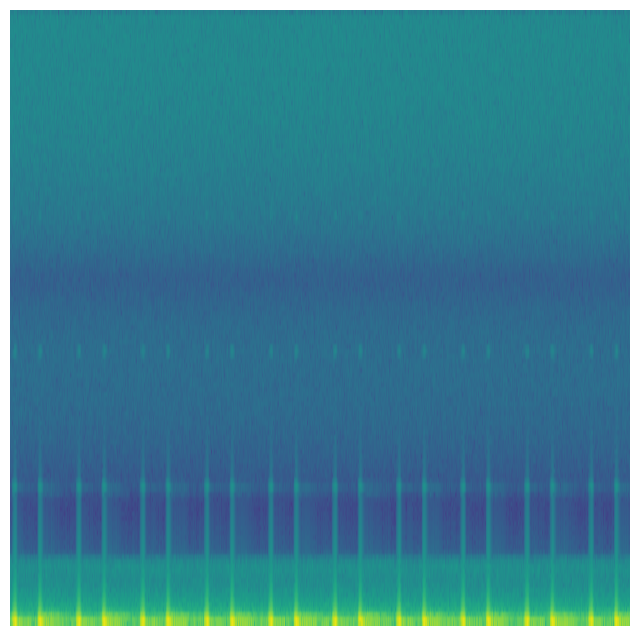

In [12]:

# %% Plot Spectrogram
plot_specgram(waveform=data_waveform, sample_rate=sr)

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchaudio
from torch.utils.data import Dataset

# Audio transformation: Convert waveform to MelSpectrogram and then to dB scale
audio_transform = torchaudio.transforms.MelSpectrogram(128)
db_transform = torchaudio.transforms.AmplitudeToDB()

# Image transformation: Resize the spectrogram image
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class SpectrogramDataset(Dataset):
    def __init__(self, wave_files, labels_files, audio_transform=None, db_transform=None, image_transform=None):
        self.wave_files = wave_files
        self.labels_files = labels_files
        self.audio_transform = audio_transform
        self.db_transform = db_transform
        self.image_transform = image_transform
        
    def __len__(self):
        return len(self.wave_files)
    
    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.wave_files[idx])

        # Mono conversion if needed
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Apply audio transformation
        if self.audio_transform:
            waveform = self.audio_transform(waveform)

        # Convert to dB scale
        if self.db_transform:
            waveform = self.db_transform(waveform)

        # Apply image transformation
        if self.image_transform:
            waveform = waveform.squeeze(0)  # Remove channel dimension for ToPILImage compatibility
            waveform = self.image_transform(waveform)

        label = self.labels_files[idx]
        return waveform, label

# Assuming train_files, train_labels_encoded, test_files, and test_labels_encoded are defined
train_dataset = SpectrogramDataset(train_files, train_labels_encoded, audio_transform=audio_transform, db_transform=db_transform, image_transform=image_transform)
test_dataset = SpectrogramDataset(test_files, test_labels_encoded, audio_transform=audio_transform, db_transform=db_transform, image_transform=image_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=2)

for batch in trainloader:
    data, labels = batch
    print("Data:", data.shape)
    print("Labels:", labels.shape)
    break


Data: torch.Size([5, 1, 224, 224])
Labels: torch.Size([5])


In [14]:
import torch
import torchvision.models as models
import torch.nn as nn

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

NUM_CLASSES = 5

class ImageMulticlassClassificationNet(nn.Module):
    def __init__(self, num_classes):
        super(ImageMulticlassClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size= 3, padding=1)  
        self.resnet = models.resnet50(weights=False)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        return self.resnet(x)



In [15]:
# Import necessary packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt  # Add this for plotting


# Assuming trainloader is defined somewhere else in your code
# trainloader = DataLoader(...)


# Assuming train_files, train_labels_encoded, test_files, and test_labels_encoded are defined
train_dataset = SpectrogramDataset(train_files, train_labels_encoded, audio_transform=audio_transform, db_transform=db_transform, image_transform=image_transform)
test_dataset = SpectrogramDataset(test_files, test_labels_encoded, audio_transform=audio_transform, db_transform=db_transform, image_transform=image_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ImageMulticlassClassificationNet(NUM_CLASSES)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define lists to store losses and accuracies
losses_epoch_mean = []
accuracies_epoch = []

# Set the number of epochs
NUM_EPOCHS = 50

model.to(device)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    losses_epoch = []
    correct = 0
    total = 0
    
    # Assuming trainloader is defined correctly
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses_epoch.append(loss.item())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    losses_epoch_mean.append(np.mean(losses_epoch))
    accuracy_epoch = 100 * correct / total
    accuracies_epoch.append(accuracy_epoch)
    
    # Get GPU memory details
    gpu_memory_allocated = torch.cuda.memory_allocated(device)
    gpu_max_memory_allocated = torch.cuda.max_memory_allocated(device)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {np.mean(losses_epoch):.4f}, Accuracy: {accuracy_epoch:.2f}%, GPU Memory Allocated: {gpu_memory_allocated / 1024**3:.2f}GB, GPU Max Memory Allocated: {gpu_max_memory_allocated / 1024**3:.2f}GB")


/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50, Loss: 1.7201, Accuracy: 23.56%, GPU Memory Allocated: 0.37GB, GPU Max Memory Allocated: 1.11GB
Epoch 2/50, Loss: 1.5507, Accuracy: 35.63%, GPU Memory Allocated: 0.37GB, GPU Max Memory Allocated: 1.11GB
Epoch 3/50, Loss: 1.5009, Accuracy: 37.36%, GPU Memory Allocated: 0.37GB, GPU Max Memory Allocated: 1.11GB
Epoch 4/50, Loss: 1.4565, Accuracy: 42.53%, GPU Memory Allocated: 0.37GB, GPU Max Memory Allocated: 1.11GB
Epoch 5/50, Loss: 1.3102, Accuracy: 53.45%, GPU Memory Allocated: 0.37GB, GPU Max Memory Allocated: 1.11GB
Epoch 6/50, Loss: 1.0612, Accuracy: 63.22%, GPU Memory Allocated: 0.37GB, GPU Max Memory Allocated: 1.11GB
Epoch 7/50, Loss: 1.0192, Accuracy: 59.77%, GPU Memory Allocated: 0.37GB, GPU Max Memory Allocated: 1.11GB
Epoch 8/50, Loss: 1.0832, Accuracy: 60.34%, GPU Memory Allocated: 0.37GB, GPU Max Memory Allocated: 1.11GB
Epoch 9/50, Loss: 0.8626, Accuracy: 67.82%, GPU Memory Allocated: 0.37GB, GPU Max Memory Allocated: 1.11GB
Epoch 10/50, Loss: 0.7585, Accuracy: 

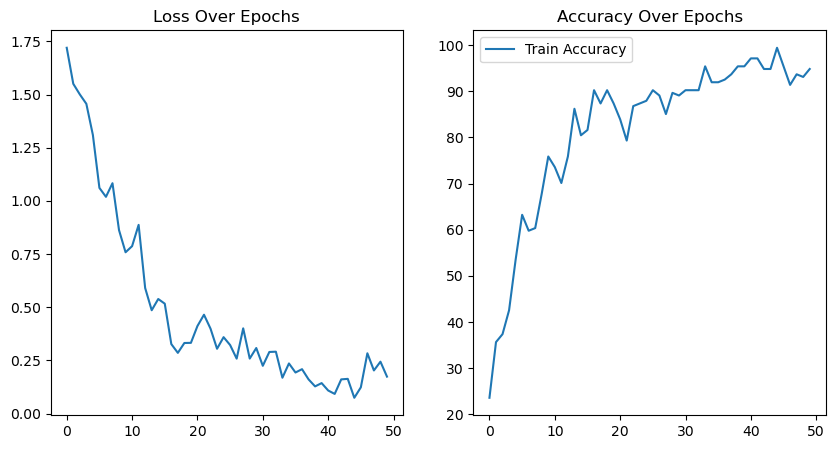

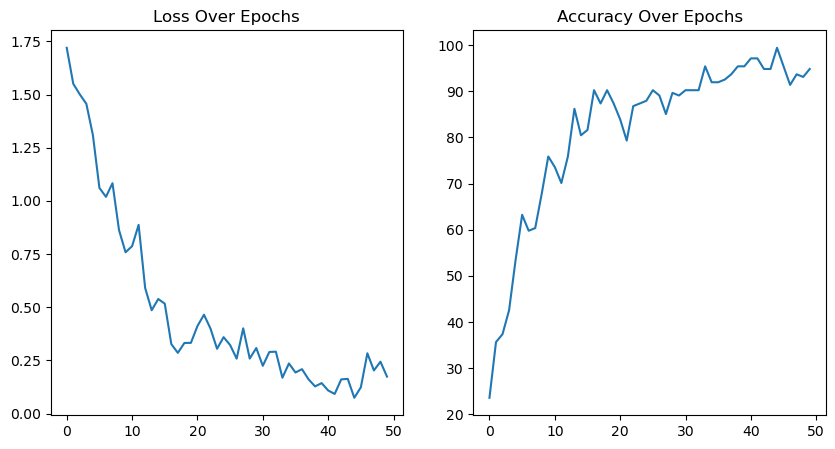

In [16]:

# Plot the losses and accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x=list(range(NUM_EPOCHS)), y=losses_epoch_mean).set_title('Loss Over Epochs')
plt.subplot(1, 2, 2)
sns.lineplot(x=list(range(NUM_EPOCHS)), y=accuracies_epoch, label='Train Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()
    

# Plot the losses and accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x=list(range(NUM_EPOCHS)), y=losses_epoch_mean).set_title('Loss Over Epochs')
plt.subplot(1, 2, 2)
sns.lineplot(x=list(range(NUM_EPOCHS)), y=accuracies_epoch).set_title('Accuracy Over Epochs')
plt.show()


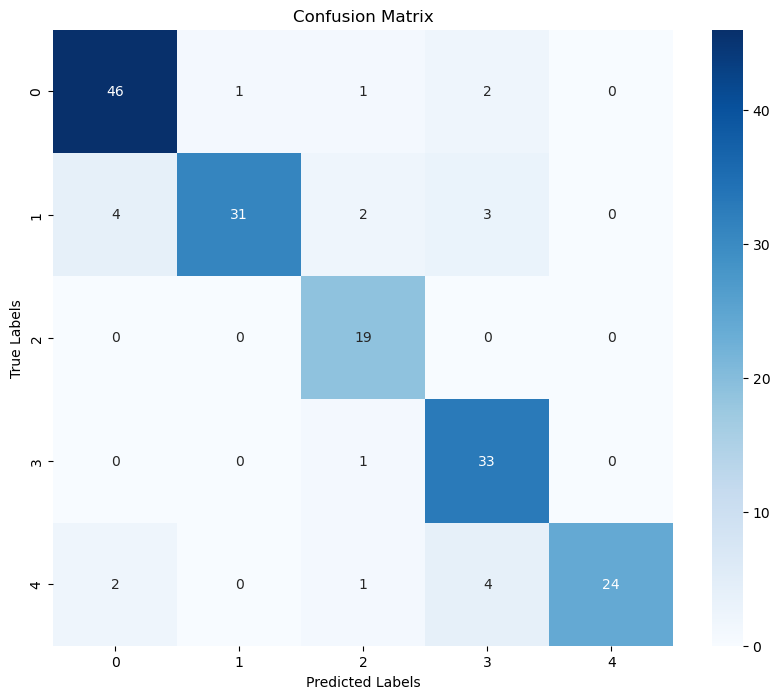

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming testloader and model are defined correctly
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend( predicted.tolist()  )
        true_labels.extend(labels.tolist())


# 


# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)


# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

